<a href="https://colab.research.google.com/github/Ndy-S/machine-learning-fundamental/blob/main/Natural%20Language%20Processing%20with%20Attention%20Models/W1_neural_machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation

## Seq2Seq
### Outline
- Introduction to Neural Machine Translation
- Seq2Seq model and its shortcomings
- Solution for the information bottleneck

### Seq2Seq model
- Introduced by Google in 2014
- Map variable-length sequences to fixed-length memory
- Inputs and outputs can have different lengths
- LSTMs and GRUs to avoid vanishing and exploding gradient problems

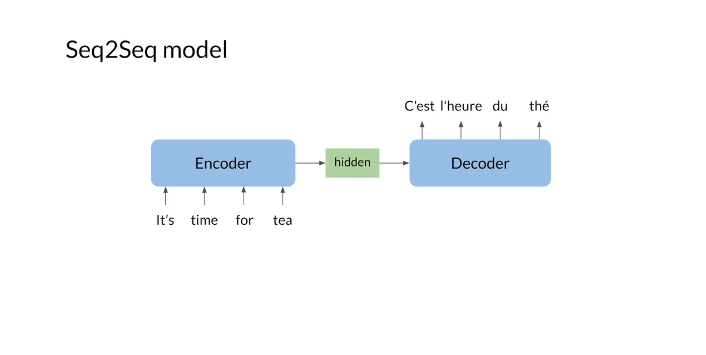

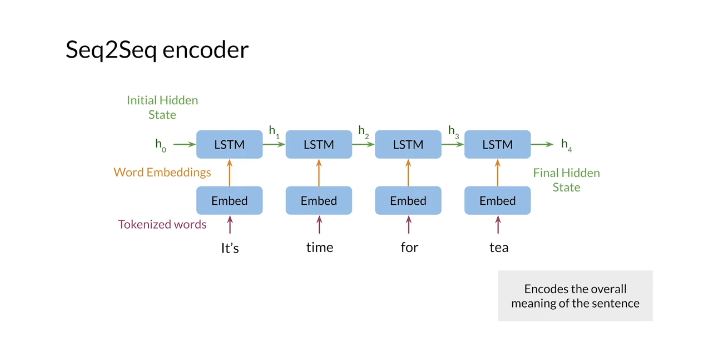

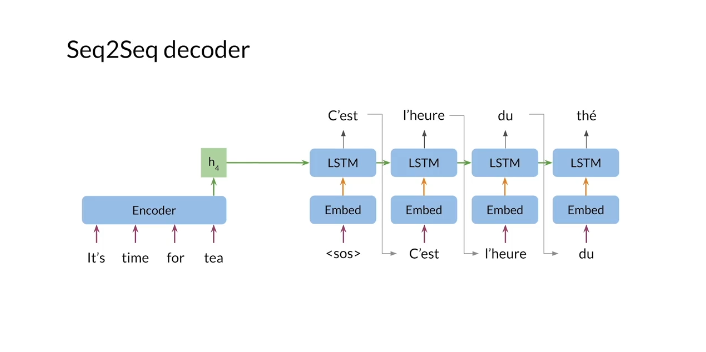

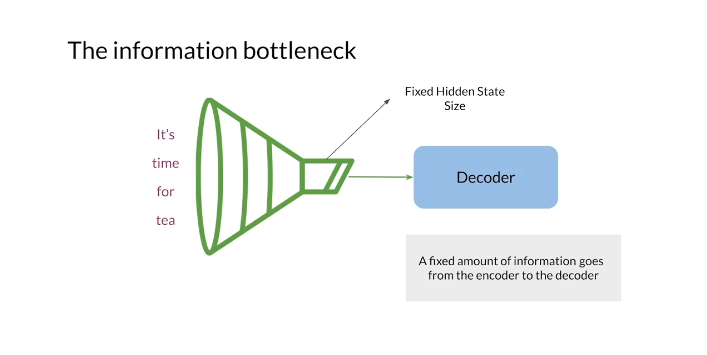

### Seq2Seq shortcomings
- Variable-length sentences + fixed-length memory
- As sequence size increases, model performance decreases

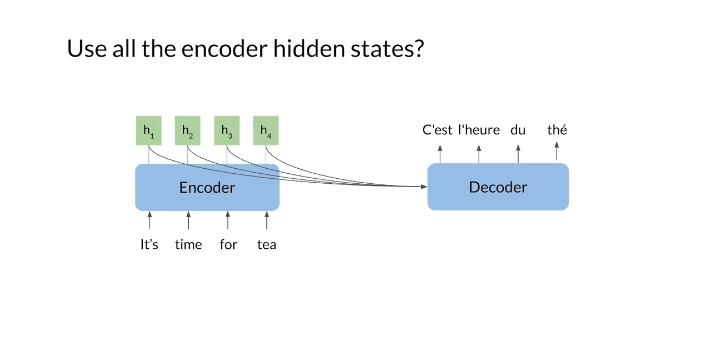

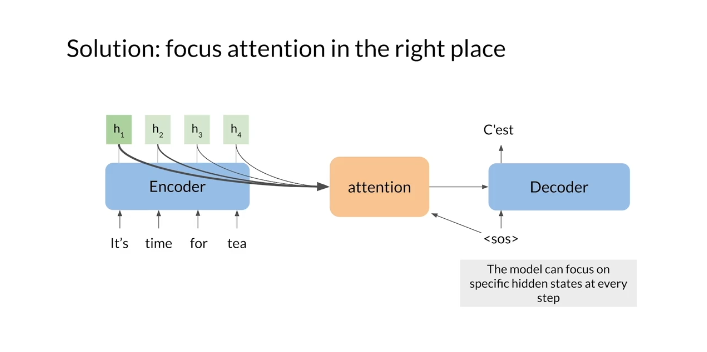

In [43]:
# SECTION DIVIDER

## Seq2Seq Model with Attention

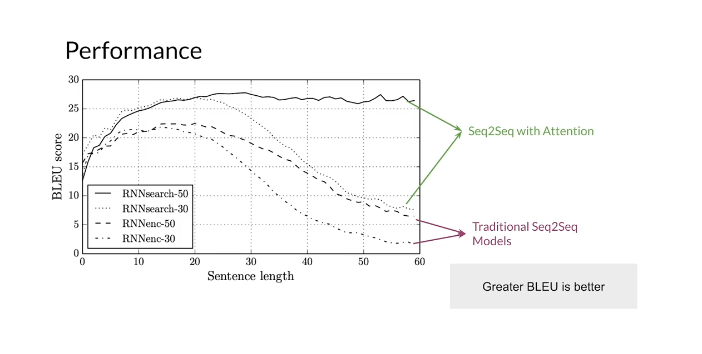

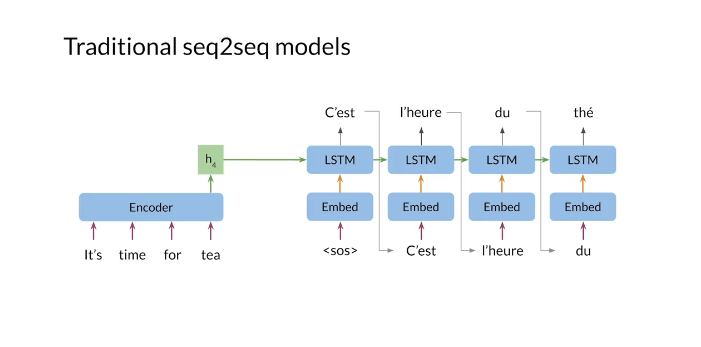

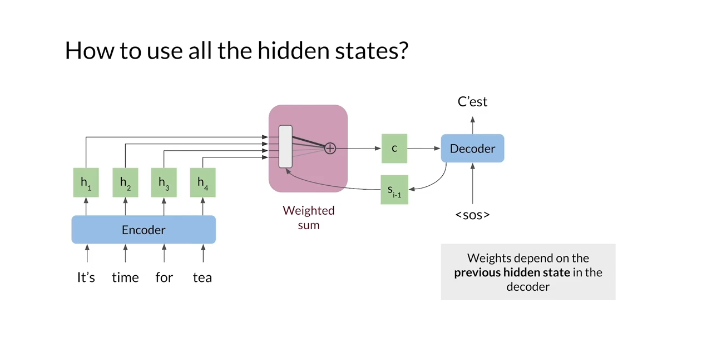

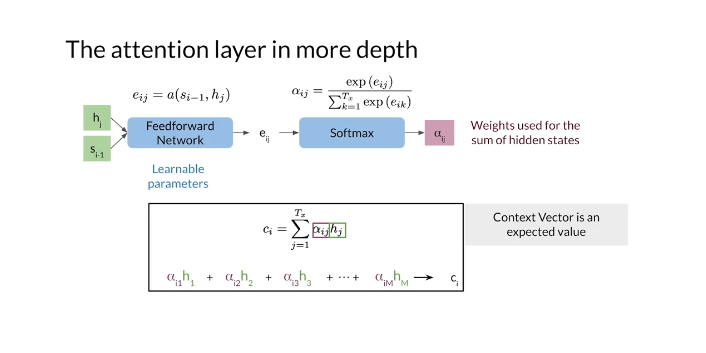

In [44]:
# SECTION DIVIDER

## Queries, Keys, Values, and Attention
### Outline
- Queries, Keys, and Values
- Alignment

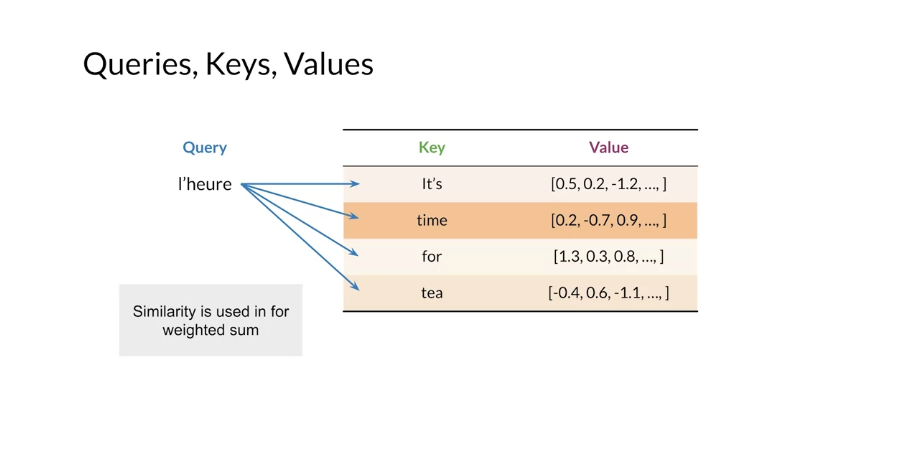

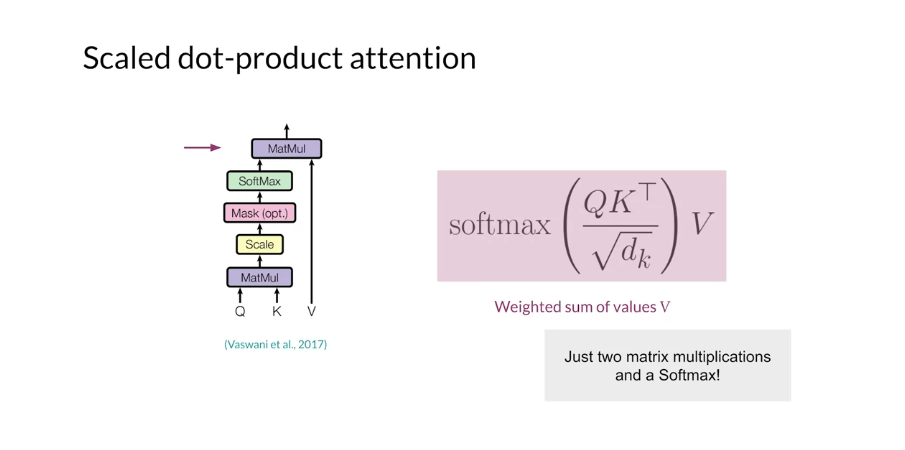

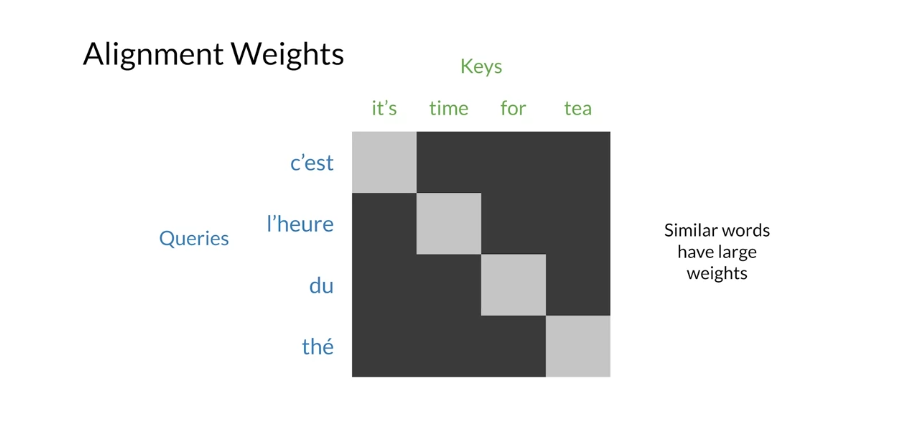

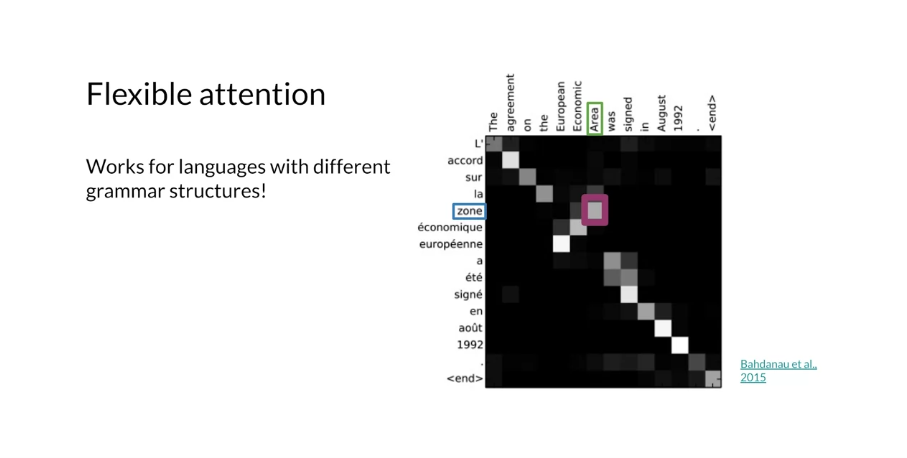

### Summary
- Attention is a layer that lets a model focus on what's important
- Queries, Values, and Key are used for information retrieval inside the Attention layer
- Works for languages with very different grammatical structures

In [45]:
# SECTION DIVIDER

## Basic Attention Code

In [46]:
import numpy as np

def softmax(x, axis=0):
  return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

In [47]:
# Calculating alignment scores
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(42)

encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

def alignment(encoder_states, decoder_state):
  inputs = np.concatenate((encoder_states, np.repeat(decoder_state, input_length, axis=0)), axis=1)
  assert inputs.shape == (input_length, 2 * hidden_size)

  activations = np.tanh(np.dot(inputs, layer_1))
  assert activations.shape == (input_length, attention_size)

  scores = np.dot(activations, layer_2)
  assert scores.shape == (input_length, 1)

  return scores

In [48]:
scores = alignment(encoder_states, decoder_state)
print(scores)

[[4.35790943]
 [5.92373433]
 [4.18673175]
 [2.11437202]
 [0.95767155]]


In [49]:
# Weight the encoder output vectors and sum
def attention(encoder_states, decoder_state):
  scores = alignment(encoder_states, decoder_state)
  weights = softmax(scores)
  weighted_scores = encoder_states * weights
  context = np.sum(weighted_scores, axis=0)
  return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]


In [50]:
# SECTION DIVIDER

## Setup for Machine Translation

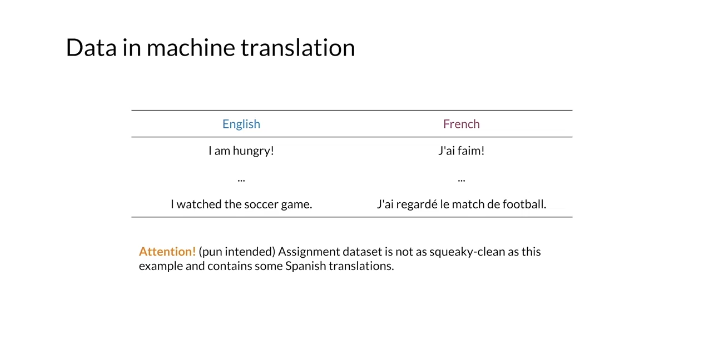

### Machine translation setup
- Use pre-trained vector embeddings
- Otherwise, initially represent words with one-hot-vectors
- Keep track of index mappings with word2ind and ind2word dictionaries
- Add end of sequence tokens: \<EOS\>
- Pad the token vectors with zeros

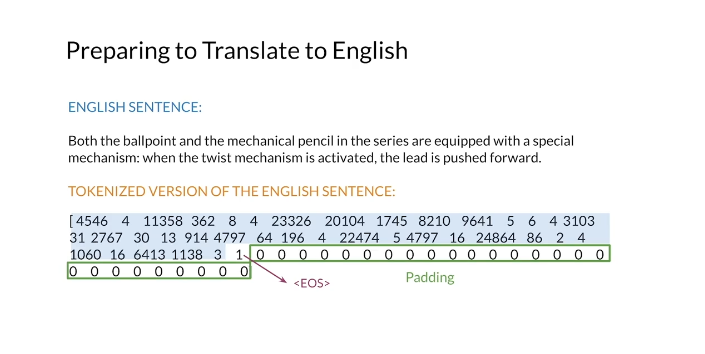

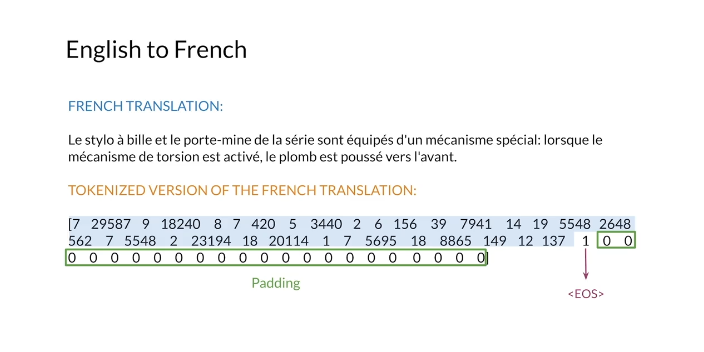

In [51]:
# SECTION DIVIDER

## Scaled Dot-Product Attention Code

In [53]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving embeddings_fr.npz to embeddings_fr.npz
Saving embeddings_en.npz to embeddings_en.npz


In [64]:
with open("./word2int_en.pkl", "rb") as f:
  en_words = pickle.load(f)

with open("./word2int_fr.pkl", "rb") as f:
  fr_words = pickle.load(f)

en_embeddings = np.load("./embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./embeddings_fr.npz")["embeddings"]

def tokenize(sentence, token_mapping):
  tokenized = []

  for word in sentence.lower().split(" "):
    try:
      tokenized.append(token_mapping[word])
    except KeyError:
      # Using -1 to indicate an unknown word
      tokenized.append(-1)

  return tokenized

def embed(tokens, embeddings):
  embed_size = embeddings.shape[1]

  output = np.zeros((len(tokens), embed_size))
  for i, token in enumerate(tokens):
    if token == -1:
      output[i] = np.zeros((1, embed_size))
    else:
      output[i] = embeddings[token]

  return output

In [65]:
def softmax(x, axis=0):
  return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

def calculate_weights(queries, keys):
    dot = np.matmul(queries, keys.T) / np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)

    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    return weights

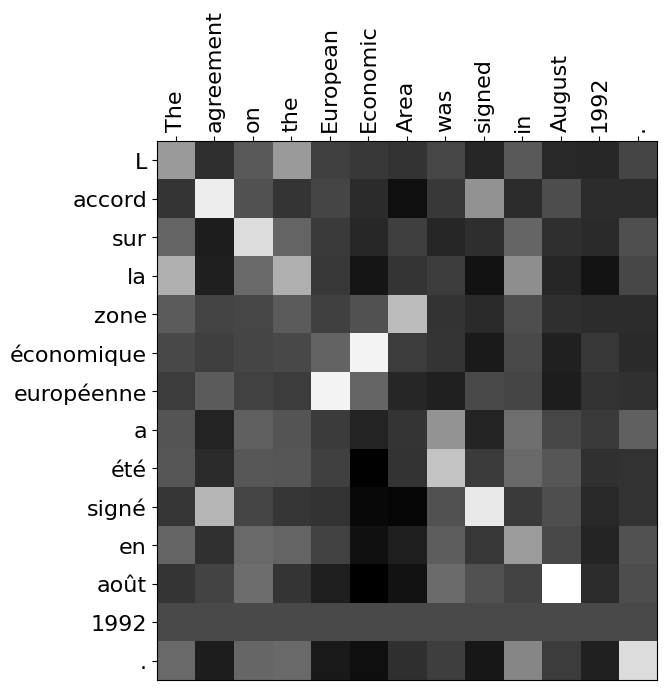

In [66]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);

In [68]:
def attention_qkv(queries, keys, values):
  weights = calculate_weights(queries, keys)
  return np.matmul(weights, values)

attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is {attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are \n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is (14, 300)
Some elements of the attention_qkv function are 
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]


In [69]:
# SECTION DIVIDER

## Teacher Forcing
### Outline
- Training for NMT
- Teacher forcing

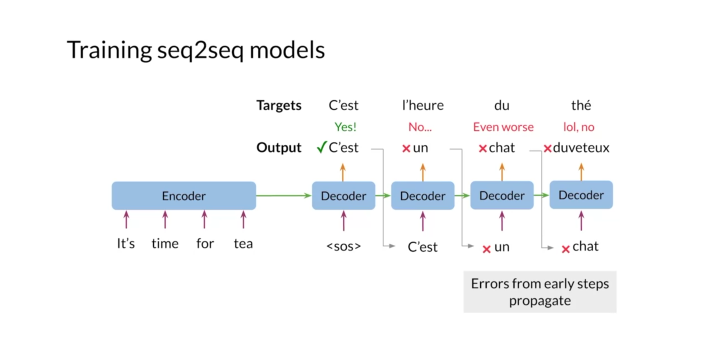

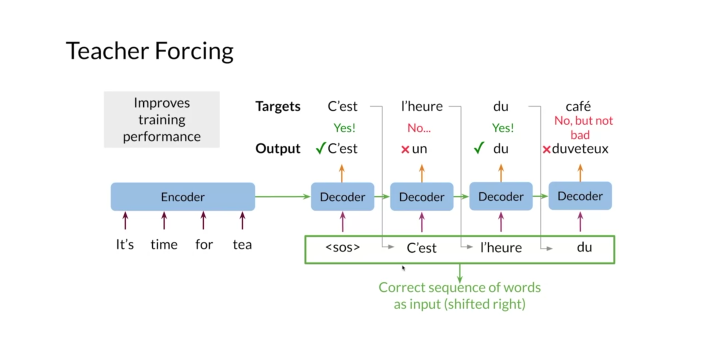

In [70]:
# SECTION DIVIDER

## NMT Model with Attention
### Outline
- How everything fits together
- NMT model in detail

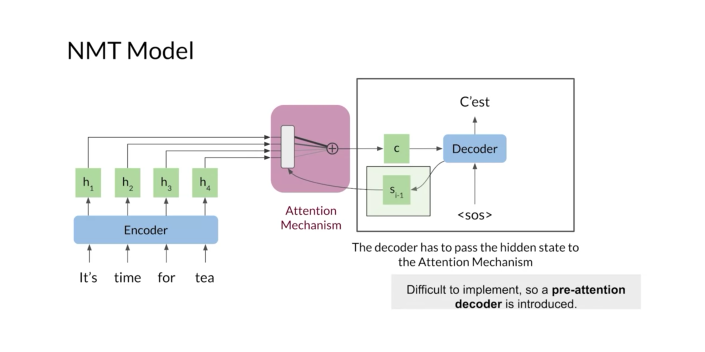

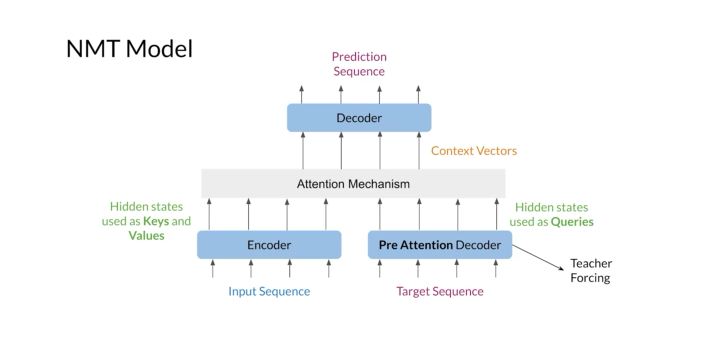

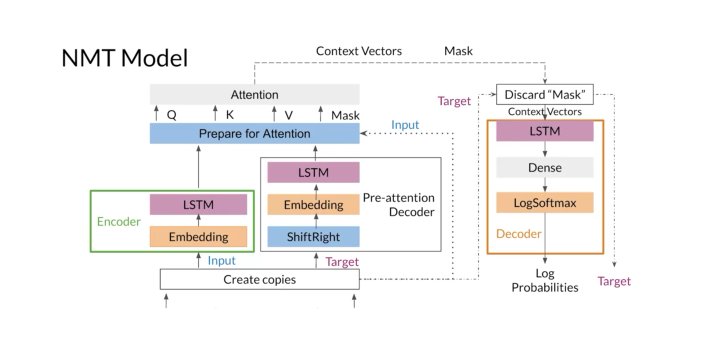

In [71]:
# SECTION DIVIDER

## BLEU Score

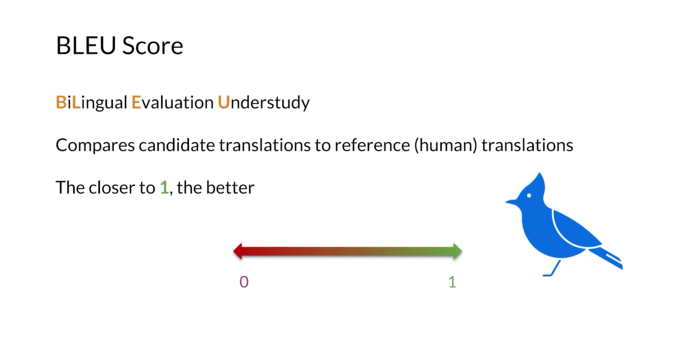

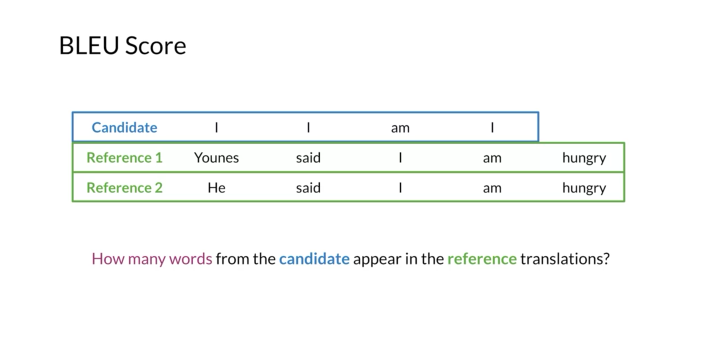

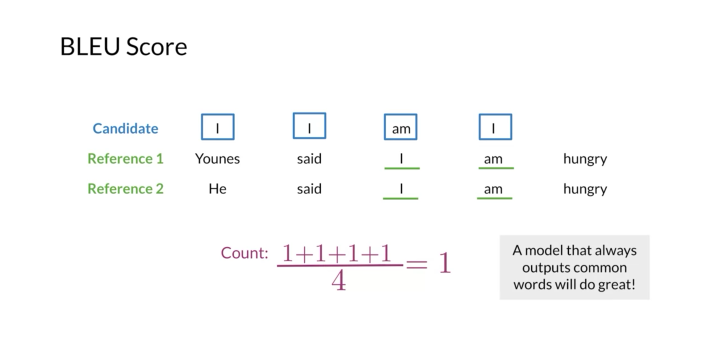

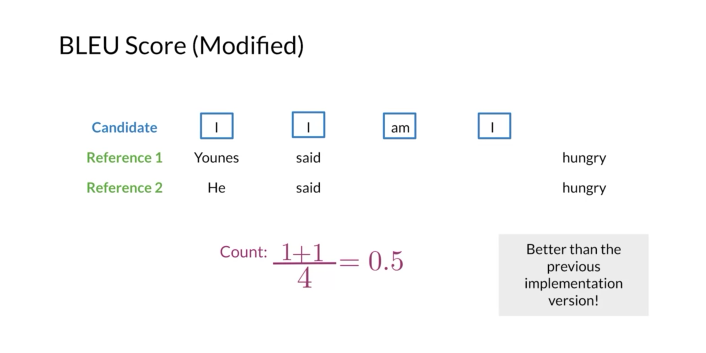

### BLEU score is great, but...
Consider the following:
- BLEU doesn't consider semantic meaning
- BLEU doesn't consider sentence structure:
  "Ate I was hungry because!"

In [72]:
# SECTION DIVIDER

# BLEU Score Code

In [74]:
import numpy as np
import nltk
nltk.download("punkt")
import math
from nltk.util import ngrams
from collections import Counter
!pip3 install 'sacrebleu'
import sacrebleu
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 2.4 MB/s eta 0:00:00


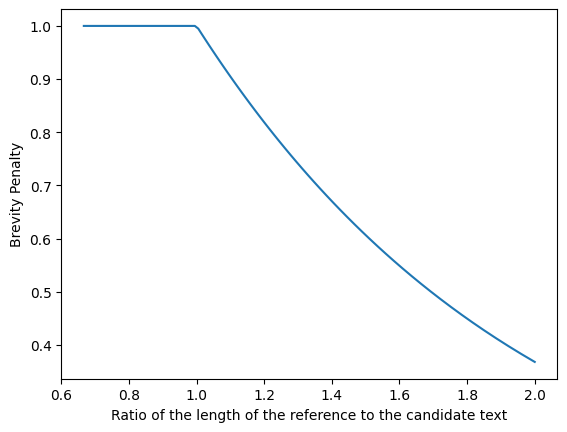

In [76]:
# Brevity Penalty (example)
ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x
y = np.exp(y)
y = np.minimum(np.ones(y.shape), y)

fig, ax = plt.subplots(1)
lines = ax.plot(x, y)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

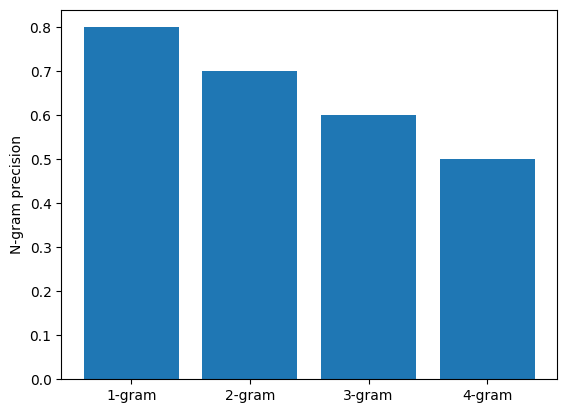

In [78]:
# N-Gram Precision (example)
data = {
    "1-gram": 0.8,
    "2-gram": 0.7,
    "3-gram": 0.6,
    "4-gram": 0.5
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")
plt.show()

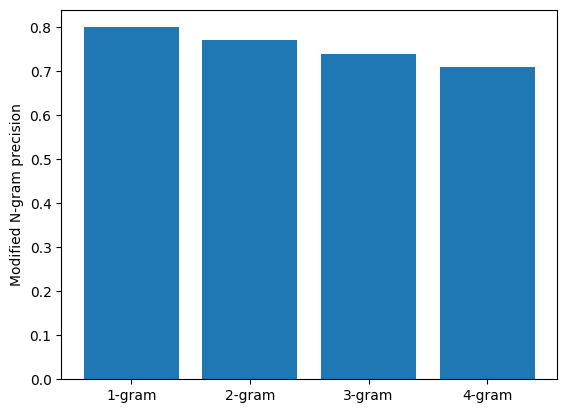

In [79]:
# N-Gram BLEU score (example)
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="Modified N-gram precision")

plt.show()

In [80]:
# Example calculations of the BLEU score
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


In [83]:
# Step 1: Computing the Brevity Penalty
def brevity_penalty(candidate, reference):
  ref_length = len(reference)
  can_length = len(candidate)

  if ref_length < can_length:
    BP = 1
  else:
    penalty = 1 - (ref_length / can_length)
    BP = np.exp(penalty)

  return BP

In [84]:
# Step 2: Computing the Precision
def clipped_precision(candidate, reference):
  clipped_precision_score = []

  for i in range(1, 5):
    ref_n_gram = Counter(ngrams(reference,i))
    cand_n_gram = Counter(ngrams(candidate,i))

    c = sum(cand_n_gram.values())

    for j in cand_n_gram:
      if j in ref_n_gram:
        if cand_n_gram[j] > ref_n_gram[j]:
          cand_n_gram[j] = ref_n_gram[j]
      else:
        cand_n_gram[j] = 0

    clipped_precision_score.append(sum(cand_n_gram.values())/c)

  weights =[0.25]*4
  s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
  s = math.exp(math.fsum(s))

  return s


In [85]:
# Step 3: Computing the BLEU score
def bleu_score(candidate, reference):
  BP = brevity_penalty(candidate, reference)
  precision = clipped_precision(candidate, reference)
  return BP * precision

In [87]:
# Step 4: Testing with our example reference and candidates sentences
print(
  "Results reference versus candidate 1 our own code BLEU: ",
  round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1),
)

print(
  "Results reference versus candidate 2 our own code BLEU: ",
  round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1),
)

Results reference versus candidate 1 our own code BLEU:  27.6
Results reference versus candidate 2 our own code BLEU:  35.3


In [88]:
# Step 5: Comparing the results from our code with the Sacrebleu library
print(
  "Results reference versus candidate 1 sacrebleu library sentence BLEU: ",
  round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1),
)
print(
  "Results reference versus candidate 2 sacrebleu library sentence BLEU: ",
  round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1),
)

Results reference versus candidate 1 sacrebleu library sentence BLEU:  27.6
Results reference versus candidate 2 sacrebleu library sentence BLEU:  35.3


In [89]:
# BLEU computation on a corpus
from google.colab import files
uploaded = files.upload()

Saving wmt19_can.txt to wmt19_can.txt
Saving wmt19_src.txt to wmt19_src.txt
Saving wmt19_ref.txt to wmt19_ref.txt


In [96]:
wmt19_src = open("./wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("./wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("./wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

In [97]:
print("English source text:")
print("\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}")
print("\n")
print("German reference translation:")
print("\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}")
print("\n")
print("German machine translation:")
print("\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:


﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:


﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'd

In [98]:
print(
  "Results reference versus candidate 1 our own BLEU implementation: ",
  round(bleu_score(tokenized_corpus_cand, tokenized_corpus_ref) * 100, 1),
)

Results reference versus candidate 1 our own BLEU implementation:  43.6


In [99]:
print(
  "Results reference versus candidate 1 sacrebleu library BLEU: ",
  round(sacrebleu.sentence_bleu(wmt19_can_1, [wmt19_ref_1]).score, 1),
)

Results reference versus candidate 1 sacrebleu library BLEU:  43.2


In [100]:
# SECTION DIVIDER

## ROUGE-N Score
### ROUGE
Recall-Oriented Understudy for Gisting Evaluation

Compares cnadidates with reference (human) translations

Multiple versions for this metric

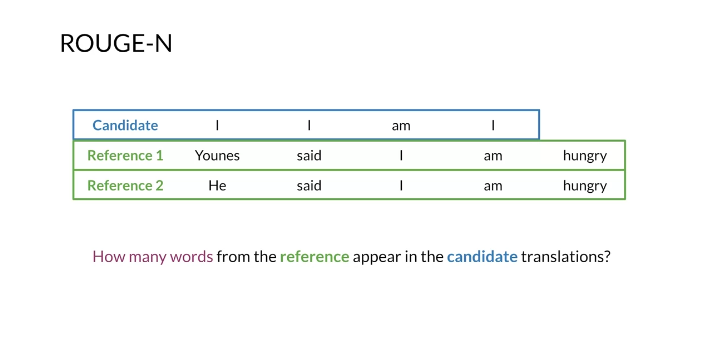

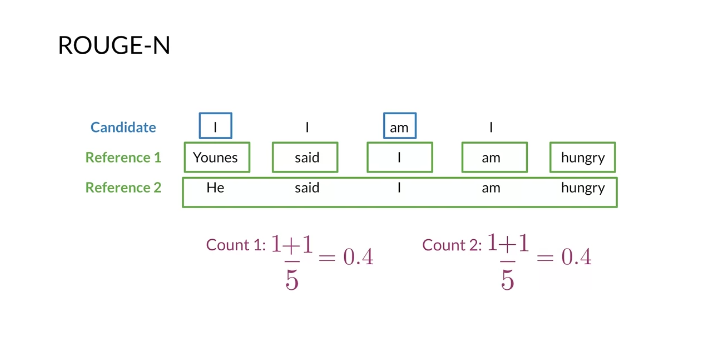

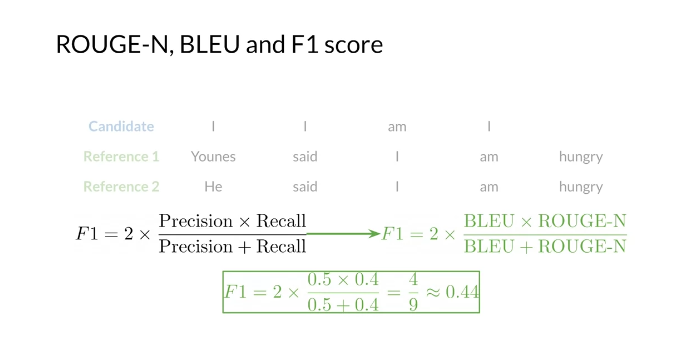

In [101]:
# SECTION DIVIDER

## Sampling and Decoding
### Outline
- Random sampling
- Temperature in sampling
- Greedy decoding

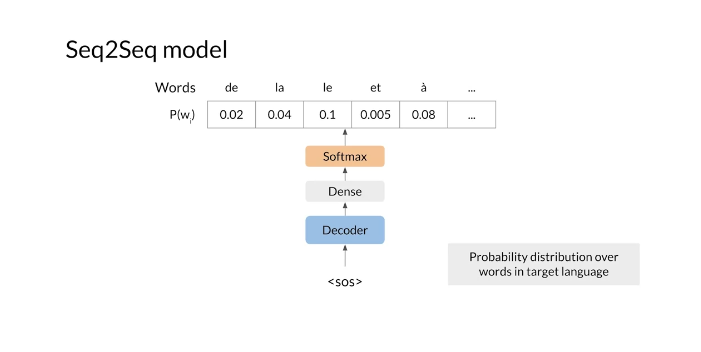

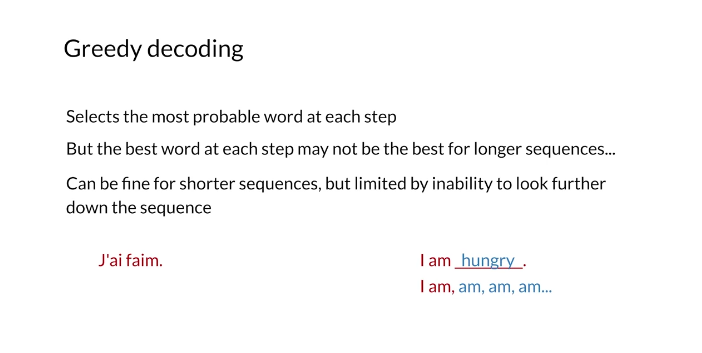

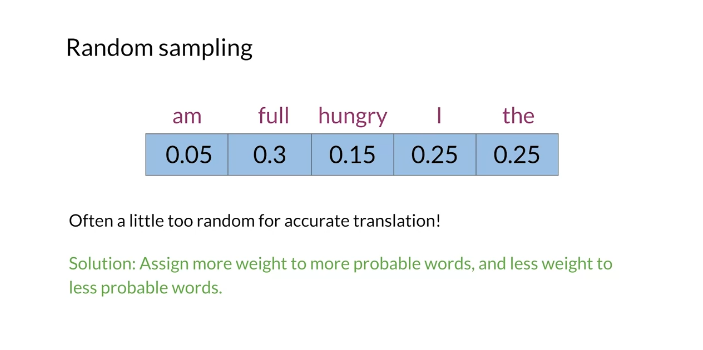

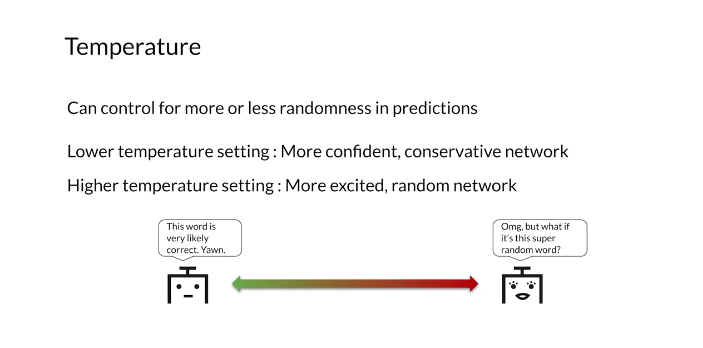

In [102]:
# SECTION DIVIDER

## Beam Search

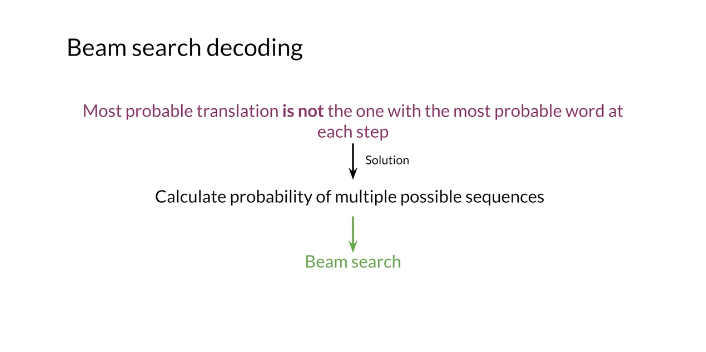

### Beam search decoding
Probability of multiple possible sequences at each step

Beam width B determines number of sequences you keep

Until all B most probable sequences end with \<EOS\>

`Beam search with B=1 is greedy decoding.`

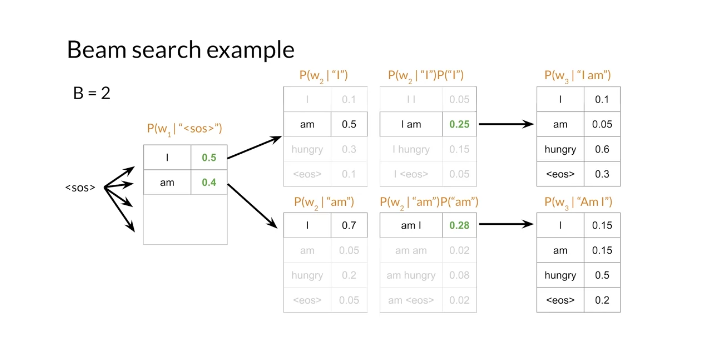

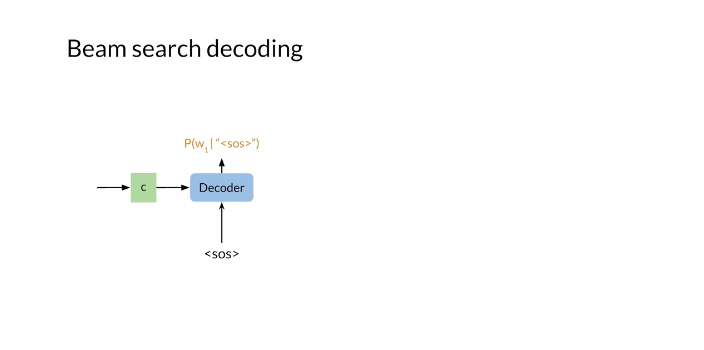

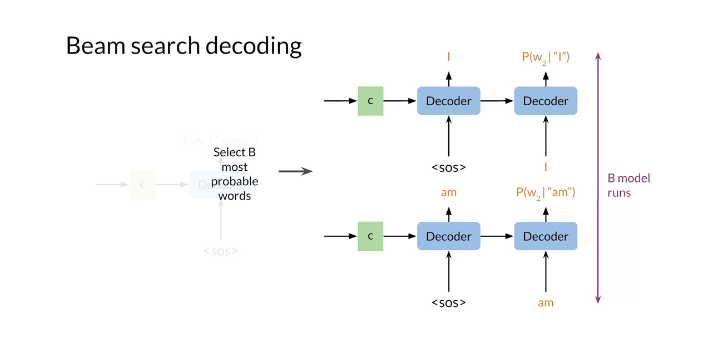

### Problems with beam search
Penalizes long sequences, so you should normalize by the sentence length

Computationally expensive and consumes a lot of memory

In [103]:
# SECTION DIVIDER

## Minimum Bayes Risk
### Minimum Bayes Risk (MBR)
- Generate several candidate translations
- Assign a similarity to every pair using a similarity score (such as ROUGE!)
- Select the sample with the highest average similarity

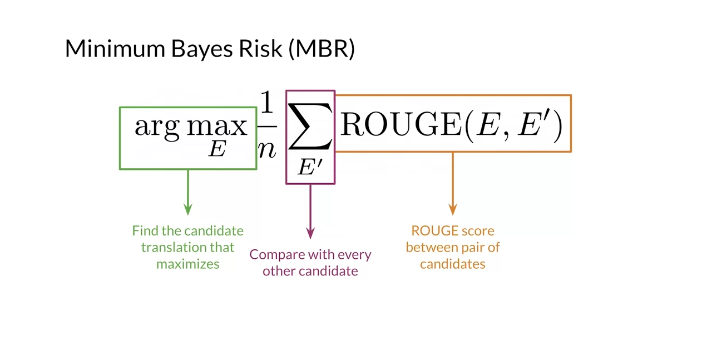

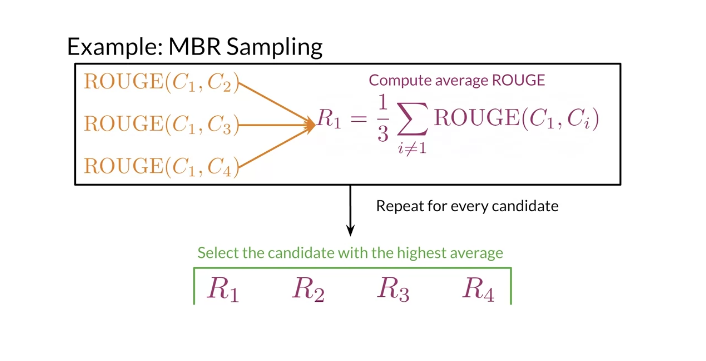

### Summary
- Compare several candidate translations
- Choose candidate with highest average similarity
- Better performance than random sampling and greedy decoding

In [104]:
# SECTION DIVIDER

## Stack Semantics Code

In [109]:
!pip install trax
from IPython.display import clear_output
clear_output(wait=False)

In [108]:
import numpy as np
from trax import layers as tl
from trax import shapes
from trax import fastmath

In [114]:
# The tl.serial combinator is stack oriented
# Defining addition
def Addition():
    layer_name = "Addition"

    def func(x, y):
        return x + y

    return tl.Fn(layer_name, func)

add = Addition()

print(f"Properties name: {add.name}, Expected inputs: {add.n_in}, Promised outputs: {add.n_out}\n")

x = np.array([3])
y = np.array([4])
print("-- Inputs --")
print("x :", x)
print("y :", y, "\n")

z = add((x, y))
print("-- Outputs --")
print("z :", z)

Properties name: Addition, Expected inputs: 2, Promised outputs: 1

-- Inputs --
x : [3]
y : [4] 

-- Outputs --
z : [7]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
# Defining multiplication
def Multiplication():
    layer_name = (
        "Multiplication"
    )

    def func(x, y):
        return x * y

    return tl.Fn(layer_name, func)


mul = Multiplication()

print(f"Properties name: {mul.name}, Expected inputs: {mul.n_in}, Promised outputs: {mul.n_out}\n")

x = np.array([7])
y = np.array([15])
print("-- Inputs --")
print("x :", x)
print("y :", y, "\n")

z = mul((x, y))
print("-- Outputs --")
print("z :", z)


Properties name: Multiplication, Expected inputs: 2, Promised outputs: 1

-- Inputs --
x : [7]
y : [15] 

-- Outputs --
z : [105]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
# Serial combinator
serial = tl.Serial(
    Addition(), Multiplication(), Addition()
)

x = (np.array([3]), np.array([4]), np.array([15]), np.array([3]))

serial.init(shapes.signature(x))

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print(f"Name: {serial.name}, Expected inputs: {serial.n_in}, Promised outputs: {serial.n_out}\nSublayers: {serial.sublayers}\n")

print("-- Inputs --")
print("x :", x, "\n")

y = serial(x)
print("-- Outputs --")
print("y :", y)

-- Serial Model --
Serial_in4[
  Addition_in2
  Multiplication_in2
  Addition_in2
] 

-- Properties --
Name: Serial, Expected inputs: 4, Promised outputs: 1
Sublayers: [Addition_in2, Multiplication_in2, Addition_in2]

-- Inputs --
x : (array([3]), array([4]), array([15]), array([3])) 

-- Outputs --
y : [108]


In [120]:
# The tl.Selector combinator in the context of the serial combinator

In [121]:
serial = tl.Serial(tl.Select([0, 1, 0, 1]), Addition(), Multiplication(), Addition())

x = (np.array([3]), np.array([4]))

serial.init(shapes.signature(x))

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print(f"Name: {serial.name}, Expected inputs: {serial.n_in}, Promised outputs: {serial.n_out}\nSublayers: {serial.sublayers}\n")

print("-- Inputs --")
print("x :", x, "\n")

y = serial(x)
print("-- Outputs --")
print("y :", y)

-- Serial Model --
Serial_in2[
  Select[0,1,0,1]_in2_out4
  Addition_in2
  Multiplication_in2
  Addition_in2
] 

-- Properties --
Name: Serial, Expected inputs: 2, Promised outputs: 1
Sublayers: [Select[0,1,0,1]_in2_out4, Addition_in2, Multiplication_in2, Addition_in2]

-- Inputs --
x : (array([3]), array([4])) 

-- Outputs --
y : [25]


In [122]:
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]), Addition(), tl.Select([0], n_in=2), Multiplication()
)

x = (np.array([3]), np.array([4]))

serial.init(shapes.signature(x))


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print(f"Name: {serial.name}, Expected inputs: {serial.n_in}, Promised outputs: {serial.n_out}\nSublayers: {serial.sublayers}\n")

print("-- Inputs --")
print("x :", x, "\n")

y = serial(x)
print("-- Outputs --")
print("y :", y)

-- Serial Model --
Serial_in2[
  Select[0,1,0,1]_in2_out4
  Addition_in2
  Select[0]_in2
  Multiplication_in2
] 

-- Properties --
Name: Serial, Expected inputs: 2, Promised outputs: 1
Sublayers: [Select[0,1,0,1]_in2_out4, Addition_in2, Select[0]_in2, Multiplication_in2]

-- Inputs --
x : (array([3]), array([4])) 

-- Outputs --
y : [28]


In [123]:
# The tl.Residual combinator in the context of the serial combinator
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]),
    tl.Residual(Addition())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print(f"Name: {serial.name}, Expected inputs: {serial.n_in}, Promised outputs: {serial.n_out}\n")

-- Serial Model --
Serial_in2_out3[
  Select[0,1,0,1]_in2_out4
  Serial_in2[
    Branch_in2_out2[
      None
      Addition_in2
    ]
    Add_in2
  ]
] 

-- Properties --
Name: Serial, Expected inputs: 2, Promised outputs: 3



In [124]:
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

-- Inputs --
(x1, x2) : (array([3]), array([4])) 

-- Outputs --
y : (array([10]), array([3]), array([4]))


In [126]:
# Modifying the network
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]),
    tl.Residual(Multiplication())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print(f"Name: {serial.name}, Expected inputs: {serial.n_in}, Promised outputs: {serial.n_out}\n")

-- Serial Model --
Serial_in2_out3[
  Select[0,1,0,1]_in2_out4
  Serial_in2[
    Branch_in2_out2[
      None
      Multiplication_in2
    ]
    Add_in2
  ]
] 

-- Properties --
Name: Serial, Expected inputs: 2, Promised outputs: 3



In [127]:
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

-- Inputs --
(x1, x2) : (array([3]), array([4])) 

-- Outputs --
y : (array([15]), array([3]), array([4]))


In [105]:
# SECTION DIVIDER

## NMT with Attention